# To Be Or Not To Be

a project for EECS 731 by Benjamin Wyss

Examining Shakespeare play data to build a classification model that predicts the player who speaks a specific line

###### python imports

In [1]:
import numpy as np
import pandas as pd
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
plt.close('all')
import warnings
warnings.filterwarnings('ignore')

### Reading Data Set From CSV

All of Shakespeare's plays, characters, lines, and acts: 

Taken from https://www.kaggle.com/kingburrito666/shakespeare-plays on 9/16/20

In [2]:
df = pd.read_csv('../data/raw/Shakespeare_data.csv')

In [3]:
df

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"
...,...,...,...,...,...,...
111391,111392,A Winters Tale,38.0,5.3.180,LEONTES,"Lead us from hence, where we may leisurely"
111392,111393,A Winters Tale,38.0,5.3.181,LEONTES,Each one demand an answer to his part
111393,111394,A Winters Tale,38.0,5.3.182,LEONTES,Perform'd in this wide gap of time since first
111394,111395,A Winters Tale,38.0,5.3.183,LEONTES,We were dissever'd: hastily lead away.


## Exploratory Data Analysis

### Cleaning the data set

Removing rows with NaN values because these rows correspond to stage directions, not characters' lines, and are thus not of value to the target classification model.

Additionally, the Dataline column is removed since it does not relate to characters' lines. Hence, it will not add value to the target classification model

In [4]:
df = df.dropna()
df = df[['Play', 'PlayerLinenumber', 'ActSceneLine', 'Player', 'PlayerLine']]

In [5]:
df

,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
3,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"
5,Henry IV,1.0,1.1.3,KING HENRY IV,And breathe short-winded accents of new broils
6,Henry IV,1.0,1.1.4,KING HENRY IV,To be commenced in strands afar remote.
7,Henry IV,1.0,1.1.5,KING HENRY IV,No more the thirsty entrance of this soil
...,...,...,...,...,...
111390,A Winters Tale,38.0,5.3.179,LEONTES,"Is troth-plight to your daughter. Good Paulina,"
111391,A Winters Tale,38.0,5.3.180,LEONTES,"Lead us from hence, where we may leisurely"
111392,A Winters Tale,38.0,5.3.181,LEONTES,Each one demand an answer to his part
111393,A Winters Tale,38.0,5.3.182,LEONTES,Perform'd in this wide gap of time since first


### Transforming the data set

###### Column Splitting

The ActSceneLine column is separated into 3 columns--Act, Scene, and Line--so that we obtain a numeric representation of this data which can be analyzed by the target classification model

In [6]:
actSceneLine = df['ActSceneLine'].str.split('.', n = 2, expand = True)
df['Act'] = pd.to_numeric(actSceneLine[0])
df['Scene'] = pd.to_numeric(actSceneLine[1])
df['Line'] = pd.to_numeric(actSceneLine[2])
df = df[['Play', 'PlayerLinenumber', 'Act', 'Scene', 'Line', 'Player', 'PlayerLine']]

In [7]:
df

,Play,PlayerLinenumber,Act,Scene,Line,Player,PlayerLine
3,Henry IV,1.0,1,1,1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,Henry IV,1.0,1,1,2,KING HENRY IV,"Find we a time for frighted peace to pant,"
5,Henry IV,1.0,1,1,3,KING HENRY IV,And breathe short-winded accents of new broils
6,Henry IV,1.0,1,1,4,KING HENRY IV,To be commenced in strands afar remote.
7,Henry IV,1.0,1,1,5,KING HENRY IV,No more the thirsty entrance of this soil
...,...,...,...,...,...,...,...
111390,A Winters Tale,38.0,5,3,179,LEONTES,"Is troth-plight to your daughter. Good Paulina,"
111391,A Winters Tale,38.0,5,3,180,LEONTES,"Lead us from hence, where we may leisurely"
111392,A Winters Tale,38.0,5,3,181,LEONTES,Each one demand an answer to his part
111393,A Winters Tale,38.0,5,3,182,LEONTES,Perform'd in this wide gap of time since first


###### One-Hot Encoding

The Play column is encoded into multiple columns via one-hot encoding since the target classification model will not be able to reason about string data. One-hot encoding is selected over label encoding since label encoding suffers from arbitrary closeness of numeric labels.

In [8]:
df = pd.get_dummies(df, columns=['Play'])

In [9]:
df

,PlayerLinenumber,Act,Scene,Line,Player,PlayerLine,Play_A Comedy of Errors,Play_A Midsummer nights dream,Play_A Winters Tale,Play_Alls well that ends well,...,Play_Richard III,Play_Romeo and Juliet,Play_Taming of the Shrew,Play_The Tempest,Play_Timon of Athens,Play_Titus Andronicus,Play_Troilus and Cressida,Play_Twelfth Night,Play_Two Gentlemen of Verona,Play_macbeth
3,1.0,1,1,1,KING HENRY IV,"So shaken as we are, so wan with care,",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,1,1,2,KING HENRY IV,"Find we a time for frighted peace to pant,",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,1,1,3,KING HENRY IV,And breathe short-winded accents of new broils,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1.0,1,1,4,KING HENRY IV,To be commenced in strands afar remote.,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1.0,1,1,5,KING HENRY IV,No more the thirsty entrance of this soil,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111390,38.0,5,3,179,LEONTES,"Is troth-plight to your daughter. Good Paulina,",0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
111391,38.0,5,3,180,LEONTES,"Lead us from hence, where we may leisurely",0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
111392,38.0,5,3,181,LEONTES,Each one demand an answer to his part,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
111393,38.0,5,3,182,LEONTES,Perform'd in this wide gap of time since first,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


###### Label Encoding

The Player column is label encoded so that we can perform statistical analysis and measure correlations between attributes. Even if we do not explicitly label encode the Player column, the target classification model would implicitly perform label encoding, and so this should not affect model performance.

In [10]:
df['Player'] = df['Player'].astype('category').cat.codes

In [11]:
df

,PlayerLinenumber,Act,Scene,Line,Player,PlayerLine,Play_A Comedy of Errors,Play_A Midsummer nights dream,Play_A Winters Tale,Play_Alls well that ends well,...,Play_Richard III,Play_Romeo and Juliet,Play_Taming of the Shrew,Play_The Tempest,Play_Timon of Athens,Play_Titus Andronicus,Play_Troilus and Cressida,Play_Twelfth Night,Play_Two Gentlemen of Verona,Play_macbeth
3,1.0,1,1,1,457,"So shaken as we are, so wan with care,",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,1,1,2,457,"Find we a time for frighted peace to pant,",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,1,1,3,457,And breathe short-winded accents of new broils,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1.0,1,1,4,457,To be commenced in strands afar remote.,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1.0,1,1,5,457,No more the thirsty entrance of this soil,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111390,38.0,5,3,179,494,"Is troth-plight to your daughter. Good Paulina,",0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
111391,38.0,5,3,180,494,"Lead us from hence, where we may leisurely",0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
111392,38.0,5,3,181,494,Each one demand an answer to his part,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
111393,38.0,5,3,182,494,Perform'd in this wide gap of time since first,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Visualizing the data set

First, calculate some basic statistics of the data set and measure correlation coefficients

In [12]:
df.describe()

,PlayerLinenumber,Act,Scene,Line,Player,Play_A Comedy of Errors,Play_A Midsummer nights dream,Play_A Winters Tale,Play_Alls well that ends well,Play_Antony and Cleopatra,...,Play_Richard III,Play_Romeo and Juliet,Play_Taming of the Shrew,Play_The Tempest,Play_Timon of Athens,Play_Titus Andronicus,Play_Troilus and Cressida,Play_Twelfth Night,Play_Two Gentlemen of Verona,Play_macbeth
count,105152.000000,105152.000000,105152.000000,105152.000000,105152.000000,105152.000000,105152.000000,105152.000000,105152.000000,105152.000000,...,105152.000000,105152.000000,105152.000000,105152.000000,105152.000000,105152.000000,105152.000000,105152.000000,105152.000000,105152.000000
mean,36.765872,2.931461,2.673587,124.258464,442.556718,0.018706,0.020561,0.031992,0.027817,0.033903,...,0.035235,0.029443,0.025078,0.021768,0.023775,0.024336,0.033200,0.023613,0.021245,0.022729
std,39.989659,1.399963,1.861746,120.504712,249.109112,0.135486,0.141909,0.175979,0.164449,0.180981,...,0.184373,0.169046,0.156363,0.145927,0.152349,0.154091,0.179158,0.151842,0.144202,0.149039
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,2.000000,1.000000,39.000000,225.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,3.000000,2.000000,89.000000,455.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,50.000000,4.000000,4.000000,172.000000,638.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,405.000000,5.000000,15.000000,971.000000,933.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
df.corr()

,PlayerLinenumber,Act,Scene,Line,Player,Play_A Comedy of Errors,Play_A Midsummer nights dream,Play_A Winters Tale,Play_Alls well that ends well,Play_Antony and Cleopatra,...,Play_Richard III,Play_Romeo and Juliet,Play_Taming of the Shrew,Play_The Tempest,Play_Timon of Athens,Play_Titus Andronicus,Play_Troilus and Cressida,Play_Twelfth Night,Play_Two Gentlemen of Verona,Play_macbeth
PlayerLinenumber,1.000000,0.092598,-0.115289,0.902706,-0.067598,-0.002330,-0.000248,0.074494,-0.009808,-0.036524,...,0.011728,-0.049613,0.008936,0.039508,0.031356,-0.037804,-0.001330,0.043530,-0.016215,-0.074446
Act,0.092598,1.000000,0.076692,0.061356,-0.005237,0.031428,0.006184,0.035150,-0.003739,-0.002089,...,-0.018167,-0.026675,-0.034550,-0.031195,0.007105,0.014653,0.000958,-0.023345,-0.011159,0.002270
Scene,-0.115289,0.076692,1.000000,-0.121451,0.000309,-0.070803,-0.102024,-0.007720,0.019251,0.297481,...,0.044976,0.022681,-0.077466,-0.092057,-0.014618,-0.066192,0.015497,0.019764,-0.002827,0.046069
Line,0.902706,0.061356,-0.121451,1.000000,-0.057687,-0.007199,0.041373,0.159082,-0.027365,-0.062125,...,0.017801,-0.053094,-0.011071,0.066185,0.023172,0.007348,-0.016590,-0.009410,-0.043323,-0.074788
Player,-0.067598,-0.005237,0.000309,-0.057687,1.000000,-0.083419,0.052297,-0.014757,-0.026526,-0.018135,...,-0.005392,0.023179,0.043473,0.001550,0.063238,0.078224,0.058573,0.060803,0.098758,0.034921
Play_A Comedy of Errors,-0.002330,0.031428,-0.070803,-0.007199,-0.083419,1.000000,-0.020004,-0.025100,-0.023355,-0.025865,...,-0.026386,-0.024048,-0.022144,-0.020596,-0.021547,-0.021806,-0.025585,-0.021472,-0.020342,-0.021056
Play_A Midsummer nights dream,-0.000248,0.006184,-0.102024,0.041373,0.052297,-0.020004,1.000000,-0.026340,-0.024508,-0.027142,...,-0.027689,-0.025235,-0.023238,-0.021613,-0.022611,-0.022883,-0.026849,-0.022532,-0.021346,-0.022096
Play_A Winters Tale,0.074494,0.035150,-0.007720,0.159082,-0.014757,-0.025100,-0.026340,1.000000,-0.030751,-0.034056,...,-0.034742,-0.031664,-0.029157,-0.027119,-0.028370,-0.028712,-0.033688,-0.028271,-0.026784,-0.027724
Play_Alls well that ends well,-0.009808,-0.003739,0.019251,-0.027365,-0.026526,-0.023355,-0.024508,-0.030751,1.000000,-0.031688,...,-0.032326,-0.029462,-0.027129,-0.025233,-0.026398,-0.026715,-0.031346,-0.026306,-0.024922,-0.025797
Play_Antony and Cleopatra,-0.036524,-0.002089,0.297481,-0.062125,-0.018135,-0.025865,-0.027142,-0.034056,-0.031688,1.000000,...,-0.035800,-0.032628,-0.030045,-0.027945,-0.029235,-0.029586,-0.034714,-0.029133,-0.027600,-0.028569


### Visualizing a subset of the data set

Because the entire data set is so large, I will perform some visual analysis on a subset of the data corresponding to lines from the play Macbeth. This will provide some small scale insights that can be scaled up and applied to a general Shakespeare Player classification model

In [14]:
macbeth = df[df['Play_macbeth'] == 1]

###### Plotting PlayerLinenumber vs Player

Observe that most of the data points in this graph are relatively thick, indicating that the data appears multiple times. This is because long lines of text are split into multiple data rows sharing the same Player and PlayerLinenumber. This means that a model that is trained to know the Player who speaks a certain PlayerLinenumber in a given play, act, and scene can use this information to perfectly predict the Player who speaks another line with identical play, act, scene, and PlayerLinenumber. We can build classification models that exploit this observation.

<AxesSubplot:title={'center':'Player vs Player Line Number'}, xlabel='PlayerLinenumber', ylabel='Player'>

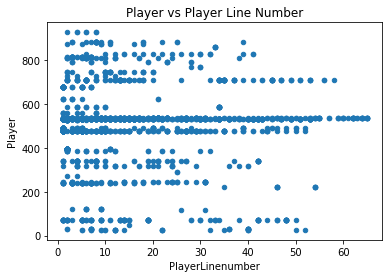

In [15]:
macbeth.plot.scatter(x='PlayerLinenumber', y='Player', title='Player vs Player Line Number')

### Feature Engineering

I propose the following ideas on how feature engineering can improve the target Player classification model:

(1): By selecting only the most promising features, I can build a model that is best set up to exploit the fact that a Player can be perfectly guessed from Play, Act, Scene, and PlayerLinenumber when the model is trained with a sample that has a matching Play, Act, Scene, and PlayerLinenumber.

(2): By performing word frequency analysis of spoken lines, I can fine-tune the above model to make more accurate Player predictions based on a given Player's most commonly spoken words. This can aid the model's predictions especially when the above exploit is not possible, such as when a perfectly aligned training sample does not exist.

###### Removing the Line Column

The Line column is removed from the data set because it merely tracks how far into a given scene a line is spoken. The PlayerLinenumber is a much more valuable attribute, because it only changes when the Player who speaks a given line changes. For these reasons, the Line column is dropped in favor of using only the PlayerLinenumber column to track line numbers.

In [16]:
df.pop('Line')
df

,PlayerLinenumber,Act,Scene,Player,PlayerLine,Play_A Comedy of Errors,Play_A Midsummer nights dream,Play_A Winters Tale,Play_Alls well that ends well,Play_Antony and Cleopatra,...,Play_Richard III,Play_Romeo and Juliet,Play_Taming of the Shrew,Play_The Tempest,Play_Timon of Athens,Play_Titus Andronicus,Play_Troilus and Cressida,Play_Twelfth Night,Play_Two Gentlemen of Verona,Play_macbeth
3,1.0,1,1,457,"So shaken as we are, so wan with care,",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,1,1,457,"Find we a time for frighted peace to pant,",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,1,1,457,And breathe short-winded accents of new broils,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1.0,1,1,457,To be commenced in strands afar remote.,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1.0,1,1,457,No more the thirsty entrance of this soil,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111390,38.0,5,3,494,"Is troth-plight to your daughter. Good Paulina,",0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
111391,38.0,5,3,494,"Lead us from hence, where we may leisurely",0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
111392,38.0,5,3,494,Each one demand an answer to his part,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
111393,38.0,5,3,494,Perform'd in this wide gap of time since first,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


###### Word Frequency Analysis

First, create a copy of the data set before word frequency analysis is applied so that machine learning models can later be compared on whether or not word frequency analysis improves their performance.

In [17]:
dfWordless = df.copy()

###### Cleaning the Text

First, punctuation is removed from the PlayerLine column since words like "hence," and "hence" should be counted as the same word. Next, hyphenated words are separated into two words since they will appear with very little frequency and not be of much use if they remain in their hyphenated form. Lastly, capital letters are replaced with lowercase letters so that words like "He" and "he" are counted as the same word.

In [18]:
df['PlayerLine'] = df['PlayerLine'].str.replace('.', '')
df['PlayerLine'] = df['PlayerLine'].str.replace('!', '')
df['PlayerLine'] = df['PlayerLine'].str.replace('?', '')
df['PlayerLine'] = df['PlayerLine'].str.replace(',', '')
df['PlayerLine'] = df['PlayerLine'].str.replace(':', '')
df['PlayerLine'] = df['PlayerLine'].str.replace(';', '')
df['PlayerLine'] = df['PlayerLine'].str.replace('-', ' ')
df['PlayerLine'] = df['PlayerLine'].str.lower()

In [19]:
df['PlayerLine']

3                   so shaken as we are so wan with care
4              find we a time for frighted peace to pant
5         and breathe short winded accents of new broils
6                 to be commenced in strands afar remote
7              no more the thirsty entrance of this soil
                               ...                      
111390     is troth plight to your daughter good paulina
111391         lead us from hence where we may leisurely
111392             each one demand an answer to his part
111393    perform'd in this wide gap of time since first
111394              we were dissever'd hastily lead away
Name: PlayerLine, Length: 105152, dtype: object

###### Calculating the Top 100 Globally Most Frequent Words

In [20]:
frequentWords = df['PlayerLine'].str.split(expand=True).stack().value_counts().head(100)

In [21]:
frequentWords

the      25992
and      23434
i        19534
to       18608
of       15439
         ...  
these     1279
some      1254
too       1220
where     1216
who       1181
Length: 100, dtype: int64

###### Calculating the Line by Line Frequency of the Top 100 Globally Most Frequent Words

To perform word frequency counts, each PlayerLine is padded with a space at the beginning and end so that the count of words can include a space at the beginning and end of the word. This prevents a word like 'area' from also counting as two instances of the word 'a'.

In [22]:
df['PlayerLine'] = ' ' + df['PlayerLine'] + ' '
for word, count in frequentWords.items():
    df[word] = df['PlayerLine'].str.count(' ' + word + ' ')

In [23]:
df

,PlayerLinenumber,Act,Scene,Player,PlayerLine,Play_A Comedy of Errors,Play_A Midsummer nights dream,Play_A Winters Tale,Play_Alls well that ends well,Play_Antony and Cleopatra,...,'tis,such,out,king,give,these,some,too,where,who
3,1.0,1,1,457,so shaken as we are so wan with care,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,1,1,457,find we a time for frighted peace to pant,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,1,1,457,and breathe short winded accents of new broils,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1.0,1,1,457,to be commenced in strands afar remote,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1.0,1,1,457,no more the thirsty entrance of this soil,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111390,38.0,5,3,494,is troth plight to your daughter good paulina,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
111391,38.0,5,3,494,lead us from hence where we may leisurely,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
111392,38.0,5,3,494,each one demand an answer to his part,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
111393,38.0,5,3,494,perform'd in this wide gap of time since first,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Model Construction

A variety of machine learning models with a variety of input features will be tested so that the best model can be selected for final validation.

The Player column is moved to the front of the data set so that it is easier to separate input features from the output class

In [24]:
playerCol = df.pop('Player')
df.insert(0, 'Player', playerCol)

dfWordless.pop('Player')
dfWordless.insert(0, 'Player', playerCol)

The PlayerLine column is removed because it has already been split into word frequency counts in one data set and is not of value to the classification model in a textual form. Next, the dataframe representation of the data is converted to input features (X) and output classes (Y) numpy arrays.

In [25]:
df.pop('PlayerLine')
array = df.values
X = array[:, 1:]
Y = array[:, 0]

dfWordless.pop('PlayerLine')
arrayWordless = dfWordless.values
XWordless = arrayWordless[:, 1:]
YWordless = arrayWordless[:, 0]

Split the data into 70% training data and 30% validation data. This split was chosen as to make overfitting less of an issue

In [26]:
X_train, X_validate, Y_train, Y_validate = train_test_split(X, Y, test_size=0.3, shuffle=True)
X_trainWordless, X_validateWordless, Y_trainWordless, Y_validateWordless = train_test_split(XWordless, YWordless, test_size=0.3, shuffle=True)

### Testing Different Models With 10-Fold Cross Validation

I will test DecisionTree, RandomForest, and NearestNeighbors models because they excel at grouping similar data together, and this should aid in exploiting the observation that identical PlayerLinenumber, Act, Scene, and Play indicates identical Player.

10-fold cross validation accuracy is selected as the scoring metric because 10-fold cross validation will reduce overfitting, and my target model will be the model that achieves the highest accuracy,

###### Generating a k=10 kFold Object to Pass to Cross-Validation Functions

All of the calls to cross_val_predict will give a warning that the least populated output class has only one member. The models trained via cross-validation will thus achieve a lower-bound accuracy score because they will not do well at predicting output classes with very few members. This should be corrected for in the validation testing of the final selected model.

In [27]:
kFold = StratifiedKFold(n_splits=10, shuffle=True)

###### Decision Tree With Word Analysis

In [28]:
decisionTreePredictions = cross_val_predict(DecisionTreeClassifier(), X_train, Y_train, cv=kFold)

In [29]:
accuracy_score(Y_train, decisionTreePredictions)

0.6908675923158438

###### Random Forest With Word Analysis

n_estimators=20 is selected due to the physical limitations of the machine that I am running this on. Attempting to create a random forest with more trees causes my machine to run out of memory.

In [30]:
randomForestPredictions = cross_val_predict(RandomForestClassifier(n_estimators=20), X_train, Y_train, cv=kFold)

In [31]:
accuracy_score(Y_train, randomForestPredictions)

0.5207048338450669

###### Nearest Neighbors With Word Analysis

In [32]:
kNeighborsPredictions = cross_val_predict(KNeighborsClassifier(), X_train, Y_train, cv=kFold)

In [33]:
accuracy_score(Y_train, kNeighborsPredictions)

0.3861913430970301

###### Decision Tree With No Word Analysis

In [34]:
decisionTreeWordlessPredictions = cross_val_predict(DecisionTreeClassifier(), X_trainWordless, Y_trainWordless, cv=kFold)

In [35]:
accuracy_score(Y_trainWordless, decisionTreeWordlessPredictions)

0.8286416868190093

###### Random Forest With No Word Analysis

n_estimators=30 is selected due to the physical limitations of the machine that I am running this on. Attempting to create a random forest with more trees causes my machine to run out of memory.

In [36]:
randomForestWordlessPredictions = cross_val_predict(RandomForestClassifier(n_estimators=30), X_trainWordless, Y_trainWordless, cv=kFold)

In [38]:
accuracy_score(Y_trainWordless, randomForestWordlessPredictions)

0.8233432057169252

###### Nearest Neighbors With No Word Analysis

In [39]:
kNeighborsWordlessPredictions = cross_val_predict(KNeighborsClassifier(), X_trainWordless, Y_trainWordless, cv=kFold)

In [40]:
accuracy_score(Y_trainWordless, kNeighborsWordlessPredictions)

0.6394315680786893

### Selecting the Best Model for Validation Testing

Out of all of the tested models, the highest accuracy was achieved by a Decision Tree without word analysis. We will perform validation testing on this model using the 30% of the data set that was not included in training.

In [57]:
model = DecisionTreeClassifier()
model.fit(X_trainWordless, Y_trainWordless)

DecisionTreeClassifier()

In [58]:
predictions = model.predict(X_validateWordless)

###### Validation Testing Accuracy of the Final Trained Model

In [59]:
accuracy_score(Y_validateWordless, predictions)

0.8358904456983453

###### Classification Report for the Validation Testing of the Final Trained Model

In [60]:
print(classification_report(Y_validateWordless, predictions))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       0.00      0.00      0.00         1
         2.0       0.00      0.00      0.00         1
         3.0       0.94      0.92      0.93        96
         4.0       0.89      1.00      0.94         8
         5.0       1.00      0.60      0.75         5
         6.0       0.00      0.00      0.00         1
         7.0       0.76      0.74      0.75        61
         8.0       0.88      0.88      0.88        25
         9.0       0.60      0.43      0.50         7
        10.0       0.85      0.85      0.85        80
        11.0       0.80      0.79      0.79        76
        12.0       0.94      1.00      0.97        50
        13.0       0.87      0.95      0.91        21
        14.0       0.91      1.00      0.95        10
        15.0       0.78      0.84      0.81        45
        16.0       0.67      0.67      0.67         6
        17.0       0.81    

### Results

Out of all the feature engineering performed, it appears that feature selection had the greatest impact on the overall accuracy of the target classification model. Exploiting the observation that identical PlayerLinenumber, Play, Act, and Scene indicates identical Player proved to be a powerful tool in building this model--especially in a decision tree model which performs very well with pattern exploitation. With the Shakespeare data set, it seems that word frequency analysis only tainted the classification models built, and as such, the decision tree model without word frequency analysis performed better than all other models tested, achieving a validation set accuracy of 83.59%. This accuracy is not bad, but could likely be improved by intensively training a deep learning classification model instead of a decision tree; however, this would be a very lengthy process.